<a href="https://colab.research.google.com/github/Arnaldgg7/BDT_MWC_Hackathon/blob/main/BDT_MWC_Arnald_Gabarrell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Individual challenge:

*   Hackathon: **#bdthackathon**
*   Author: **Arnald Gabarrell**



In [ ]:
# Loading the required packages:
import math
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import seaborn as sb
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedStratifiedKFold

# IMPORTANT: Uncomment the following line and install featuretools, if not installed in the Google Colab instance, and then click on 'RESTART RUNTIME'
# in order to set all new configuration for Pandas to deal with this library. Otherwise, you will get an error:
# !pip install featuretools
import featuretools as ft

# **Data Exploration**

In [ ]:
# Reading the CSV file:
url = "https://raw.githubusercontent.com/nuwe-io/bdt_hackathon/main/particles.csv"
df = pd.read_csv(url)

In [ ]:
df.head()

,alpha_1,alpha_2,alpha_3,beta_1,beta_2,beta_3,gamma_1,gamma_2,gamma_3,theta,noise,Particle
0,NaN,-59.730861,396.928620,9.761703,-137.558889,159.598109,-137.558889,53.930955,154.713810,-232.436087,99.243140,3
1,147.781782,153.729532,111.998962,-174.941235,-97.888332,26.493593,-97.888332,-30.506871,-166.347802,-195.010710,20.242743,0
2,242.220616,82.947635,-102.073856,116.334349,-101.746729,176.452823,-101.746729,-33.419984,44.082548,-173.928682,3.806943,1
3,140.542086,-110.129037,215.560355,-11.927860,-11.257902,21.648833,-11.257902,240.685680,133.441269,-276.382025,0.336025,0
4,169.367809,-92.182925,159.995515,-272.230740,-80.483153,-97.698901,-80.483153,16.251613,-13.177148,-100.316959,24.459551,0


In [ ]:
df.shape

(127321, 12)

In [ ]:
df.dtypes

alpha_1     float64
alpha_2     float64
alpha_3     float64
beta_1      float64
beta_2      float64
beta_3      float64
gamma_1     float64
gamma_2     float64
gamma_3     float64
theta       float64
noise       float64
Particle      int64
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127321 entries, 0 to 127320
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alpha_1   109132 non-null  float64
 1   alpha_2   127321 non-null  float64
 2   alpha_3   127321 non-null  float64
 3   beta_1    127321 non-null  float64
 4   beta_2    127131 non-null  float64
 5   beta_3    127206 non-null  float64
 6   gamma_1   127321 non-null  float64
 7   gamma_2   126594 non-null  float64
 8   gamma_3   117897 non-null  float64
 9   theta     126595 non-null  float64
 10  noise     127321 non-null  float64
 11  Particle  127321 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 11.7 MB


In [ ]:
# NA values per variable and class:
df.drop('Particle', 1).isna().groupby(df.Particle, sort=False).sum().reset_index()

,Particle,alpha_1,alpha_2,alpha_3,beta_1,beta_2,beta_3,gamma_1,gamma_2,gamma_3,theta,noise
0,3,2568,0,0,0,26,15,0,92,1355,101,0
1,0,4620,0,0,0,49,26,0,171,2304,174,0
2,1,3865,0,0,0,38,26,0,157,2053,173,0
3,2,5955,0,0,0,65,41,0,260,3124,234,0
4,7,413,0,0,0,5,1,0,17,207,20,0
5,4,260,0,0,0,0,1,0,11,137,9,0
6,5,335,0,0,0,4,2,0,13,157,12,0
7,6,173,0,0,0,3,3,0,6,87,3,0


In [ ]:
# NA values totals per variable:
df.drop('Particle', 1).isna().groupby(df.Particle, sort=False).sum().reset_index().drop('Particle', 1).sum()

alpha_1    18189
alpha_2        0
alpha_3        0
beta_1         0
beta_2       190
beta_3       115
gamma_1        0
gamma_2      727
gamma_3     9424
theta        726
noise          0
dtype: int64

In [ ]:
df.describe()

,alpha_1,alpha_2,alpha_3,beta_1,beta_2,beta_3,gamma_1,gamma_2,gamma_3,theta,noise,Particle
count,109132.000000,127321.000000,127321.000000,127321.000000,127131.000000,127206.000000,127321.000000,126594.000000,117897.000000,126595.000000,127321.000000,127321.000000
mean,-10.713873,-0.270224,49.546923,7.508049,46.853638,0.451485,46.845556,-0.040888,-20.881407,-61.594057,50.126020,1.647804
std,152.987128,100.044696,221.503776,164.993428,160.134335,99.979061,160.142626,99.797656,160.637008,146.954921,28.848755,1.470649
min,-779.841923,-391.102365,-1263.945127,-701.930722,-655.626984,-448.118855,-655.626984,-435.684650,-719.937495,-653.437102,0.000390,0.000000
25%,-118.765902,-68.036224,-102.428650,-109.328232,-59.311413,-66.838936,-59.320379,-67.011881,-133.157334,-158.912087,25.125602,0.000000
50%,-0.787086,-0.112444,48.483502,6.053932,55.785954,0.571383,55.772838,-0.265758,-14.309868,-75.169482,50.213148,2.000000
75%,101.815933,66.895676,198.157415,123.154096,155.939039,67.675433,155.939228,66.893239,95.426099,20.771011,75.115084,2.000000
max,698.044837,444.209708,1383.265329,666.078562,726.063419,448.925730,726.063419,544.546234,682.413287,689.548943,99.993348,7.000000


In [ ]:
# Checking balance among classes:
df.Particle.value_counts()

2    42060
0    32197
1    27340
3    17727
7     2854
5     2269
4     1704
6     1170
Name: Particle, dtype: int64

In [ ]:
df.duplicated().sum()

0

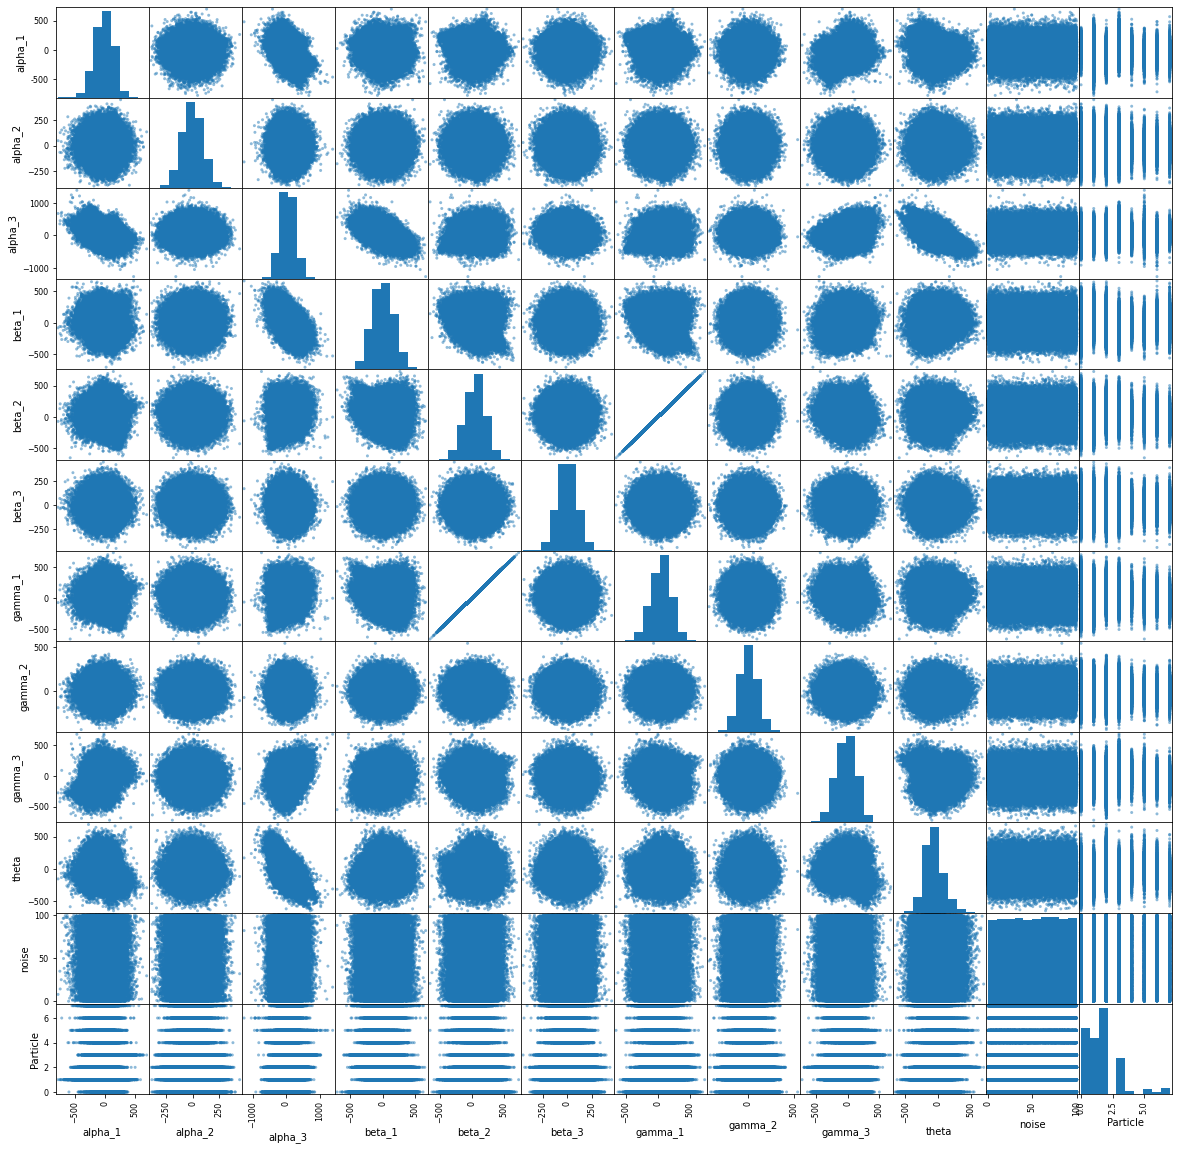

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(20,20));

In [ ]:
df.corr()

,alpha_1,alpha_2,alpha_3,beta_1,beta_2,beta_3,gamma_1,gamma_2,gamma_3,theta,noise,Particle
alpha_1,1.000000,-0.000016,-0.356387,0.006568,-0.132574,0.005763,-0.132610,0.001136,0.315485,-0.125341,0.000454,-0.290475
alpha_2,-0.000016,1.000000,0.001051,0.000253,-0.004802,0.000502,-0.004744,-0.000751,-0.000862,-0.001576,0.001311,-0.004861
alpha_3,-0.356387,0.001051,1.000000,-0.584323,0.122645,-0.000564,0.122683,-0.003794,0.208080,-0.657674,0.004392,0.157332
beta_1,0.006568,0.000253,-0.584323,1.000000,-0.135107,-0.000817,-0.135118,-0.000623,0.157325,0.098054,-0.000839,-0.138840
beta_2,-0.132574,-0.004802,0.122645,-0.135107,1.000000,-0.003177,1.000000,0.004026,-0.099809,0.022734,0.001867,0.107342
beta_3,0.005763,0.000502,-0.000564,-0.000817,-0.003177,1.000000,-0.003249,-0.005284,0.007687,0.000698,-0.001978,0.004232
gamma_1,-0.132610,-0.004744,0.122683,-0.135118,1.000000,-0.003249,1.000000,0.003932,-0.099939,0.022653,0.002128,0.107423
gamma_2,0.001136,-0.000751,-0.003794,-0.000623,0.004026,-0.005284,0.003932,1.000000,-0.004616,0.004802,0.000309,0.000807
gamma_3,0.315485,-0.000862,0.208080,0.157325,-0.099809,0.007687,-0.099939,-0.004616,1.000000,-0.189019,0.004138,-0.017046
theta,-0.125341,-0.001576,-0.657674,0.098054,0.022734,0.000698,0.022653,0.004802,-0.189019,1.000000,-0.004534,0.126064


## **Conclusions of Data Exploration:**


*   Dataset with considerable Cardinality (127321 observations) and reasonable Dimensionality (11 potential predictor variables, plus the response variable).

*   There are many NULL values in many of the variables, but no duplicates. Class 'alpha_1' gathers most of the NULL values, as well as class 'gamma_3'.

*   The range of values among variables is very different (up to 3 orders of magnitude), so Normalization is going to be a useful tool to balance variable importance among features and boost model performance overall.

*   The dataset is highly imbalanced, which should be factored in the pre-processing and models, so that the classes with the least representation in the overall sample don't get excessively penalyzed by the corresponding classifiers.

*   The predictor variables show relevant correlations among them. This is clearly the case of 'gamma_1' and 'beta_2', which shows perfect positive correlation, as well as almost exactly the same correlation with the response variable. Therefore, we should tackle this Multicollinearity problem by means of removing one of these variables, since it leads to unstable predictions, especially in case of regression-related approaches, as well as it is an increase of dimensionality with no benefit in terms or predictions.

  In case of 'theta' and 'alpha_3' there is a slightly negative correlation (-0.66), but recall we are in a Machine Learning context, whereby we don't care about the interpretation of the results based on the predictors, but about the predictors that are just perfectly correlated (Pearson Correlation of '1') and, therefore, they are not adding any benefit to our predictions, just dimensionality. As long as they are not perfectly correlated and when measuring the variable importance they end up being relevant, we should keep them.

*   The probability density function (PDF) of all preditor variables looks like a Gaussian Distribution, except for the Noise variable that, assuming it is 'White Noise', it is showing a Constant Distribution that provides no relevant information about the existing features (uncorrelated observations).







# **Data Wrangling**

### **Removing Collinearity**

First, we will get rid of the Multicollinearity within the dataset. To do so, we are going to remove either 'gamma_1' or 'beta_2'. If we pay attention to the above information, we see that 'beta_2' holds missing values, whereas 'gamma_1' not. Thus, it seems wiser to remove the redundant variable that we have more data about.

This is the rationale whereby we decide to remove 'beta_2' from the dataset:

In [ ]:
df2 = df.drop('beta_2', 1)

In [ ]:
# Checking it has been removed:
df2.head()

,alpha_1,alpha_2,alpha_3,beta_1,beta_3,gamma_1,gamma_2,gamma_3,theta,noise,Particle
0,NaN,-59.730861,396.928620,9.761703,159.598109,-137.558889,53.930955,154.713810,-232.436087,99.243140,3
1,147.781782,153.729532,111.998962,-174.941235,26.493593,-97.888332,-30.506871,-166.347802,-195.010710,20.242743,0
2,242.220616,82.947635,-102.073856,116.334349,176.452823,-101.746729,-33.419984,44.082548,-173.928682,3.806943,1
3,140.542086,-110.129037,215.560355,-11.927860,21.648833,-11.257902,240.685680,133.441269,-276.382025,0.336025,0
4,169.367809,-92.182925,159.995515,-272.230740,-97.698901,-80.483153,16.251613,-13.177148,-100.316959,24.459551,0


### **Dealing with NA values**

Since the number of missing values is huge in many variables, especially the aforementioned ones, we are going to use an iterative approach to fill those missing values by means of the rest of the variable values for each observation.

To do so, we are going to use the Scikit-Learn implementation of an iterative imputation model (also known as **MICE approach of Multivariate Imputation by Chained Equations**). The Scikit-Learn implementation uses to achieve this goal a **Bayesian Ridge model** using all other available features to figure out the missing values. It also uses an ascending approach by default (filling first the NA values from observations with most available values), which is suitable in most of the settings, as well as '10' iterations to refine each figured value, being consistent enough given available studies and tests when using this approach.

In [ ]:
imputer = IterativeImputer()
imputer.fit(df2)
df3 = imputer.transform(df2)

In [ ]:
df3 = pd.DataFrame(df3, columns=df2.columns)

In [ ]:
# Checking we get the same dataset as in the outset:
df3.describe()

,alpha_1,alpha_2,alpha_3,beta_1,beta_3,gamma_1,gamma_2,gamma_3,theta,noise,Particle
count,127321.000000,127321.000000,127321.000000,127321.000000,127321.000000,127321.000000,127321.000000,127321.000000,127321.000000,127321.000000,127321.000000
mean,-10.604616,-0.270224,49.546923,7.508049,0.451459,46.845556,-0.040905,-20.991281,-61.611413,50.126020,1.647804
std,152.860563,100.044696,221.503776,164.993428,99.933899,160.142626,99.512329,160.709055,146.951345,28.848755,1.470649
min,-779.841923,-391.102365,-1263.945127,-701.930722,-448.118855,-655.626984,-435.684650,-724.085457,-653.437102,0.000390,0.000000
25%,-118.701504,-68.036224,-102.428650,-109.328232,-66.776667,-59.320379,-66.579846,-133.145178,-158.906311,25.125602,0.000000
50%,-0.708033,-0.112444,48.483502,6.053932,0.559451,55.772838,-0.150763,-14.331698,-75.171974,50.213148,2.000000
75%,101.855926,66.895676,198.157415,123.154096,67.598300,155.939228,66.464088,95.181071,20.697874,75.115084,2.000000
max,698.044837,444.209708,1383.265329,666.078562,448.925730,726.063419,544.546234,682.413287,689.548943,99.993348,7.000000


In [ ]:
# NA values per variable and class:
df3.drop('Particle', 1).isna().groupby(df.Particle, sort=False).sum().reset_index()

,Particle,alpha_1,alpha_2,alpha_3,beta_1,beta_3,gamma_1,gamma_2,gamma_3,theta,noise
0,3,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,0,0,0,0,0,0,0
6,5,0,0,0,0,0,0,0,0,0,0
7,6,0,0,0,0,0,0,0,0,0,0


### **Assessing the importance of 'noise' feature**

Additionally, we must assess whether the 'noise' feature is actually adding value to our predictions or not. We are treating it differently, as its Probability Density Distribution is different from the rest of the variables, so we must decide from the very outset if we keep it for further processing or we can get rid of it, as it doesn't provide any benefit or is making worse the predictions.

We are going to do so by means of a Random Forest and its implicit 'variable importance' attribute, which is got by permuting observations for each variable and evaluating the changes in the out-of-bag score. So, it is very robust and reliable to get such information:

In [ ]:
# Functions to use:
def feat_importance(rf, col_names):
    f_imp = pd.DataFrame(
        {
            "var": col_names,
            "feat_imp": rf.feature_importances_
        })
    return(f_imp.sort_values(by=["feat_imp"], axis=0, ascending=False))

def feat_importance_plot(f_imp):
    plt.title('Feature Importances')
    plt.barh(range(len(f_imp)), f_imp.feat_imp, color='b', align='center')
    plt.yticks(range(len(f_imp)), f_imp['var'])
    plt.xlabel('Relative Importance')
    plt.show()

In [ ]:
# Creating train-test splits to be used in the Random Forest and determine variable importance:
X_temp = df3.drop('Particle', axis = 1) # Drop column on the column axis
y_temp = df3['Particle'].values         # df['class'] gives us a pandas series, we need an array, which can be obtained using .values
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

In [ ]:
# Creating and training the model, and getting variable importance:
model = RandomForestClassifier()
model.fit(X_train_t, y_train_t)
importance = model.feature_importances_

Feature: alpha_1, Score: 20.7%
Feature: alpha_2, Score: 3.78%
Feature: alpha_3, Score: 9.09%
Feature: beta_1, Score: 12.02%
Feature: beta_3, Score: 3.75%
Feature: gamma_1, Score: 15.39%
Feature: gamma_2, Score: 3.8%
Feature: gamma_3, Score: 15.28%
Feature: theta, Score: 12.43%
Feature: noise, Score: 3.76%


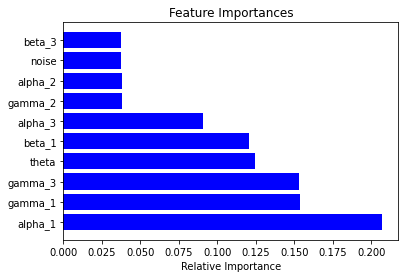

In [ ]:
for imp, var in enumerate(importance):
	print('Feature: {}, Score: {}%'.format(df3.columns[imp],round(var*100,2)))

# Sorting variables by importance and plotting them:
f_imp = feat_importance(model, X_train_t.columns)
feat_importance_plot(f_imp)

As shown, 'noise' variable is not less important than at least 3 other variables within the dataset. Thus, we should not treat it differently than the rest of the variables and we must keep it to decide further on along with the rest of the variables which are relevant and which are not as a global Feature Selection process.

### **Outlier Detection**

From a Univariate Standpoint, we can plot the following Box-Plots for each variable to get an idea about the potential outliers we might have in our data, which can skew or hinder the classification of each class by the Machine Learning Classifiers later on:

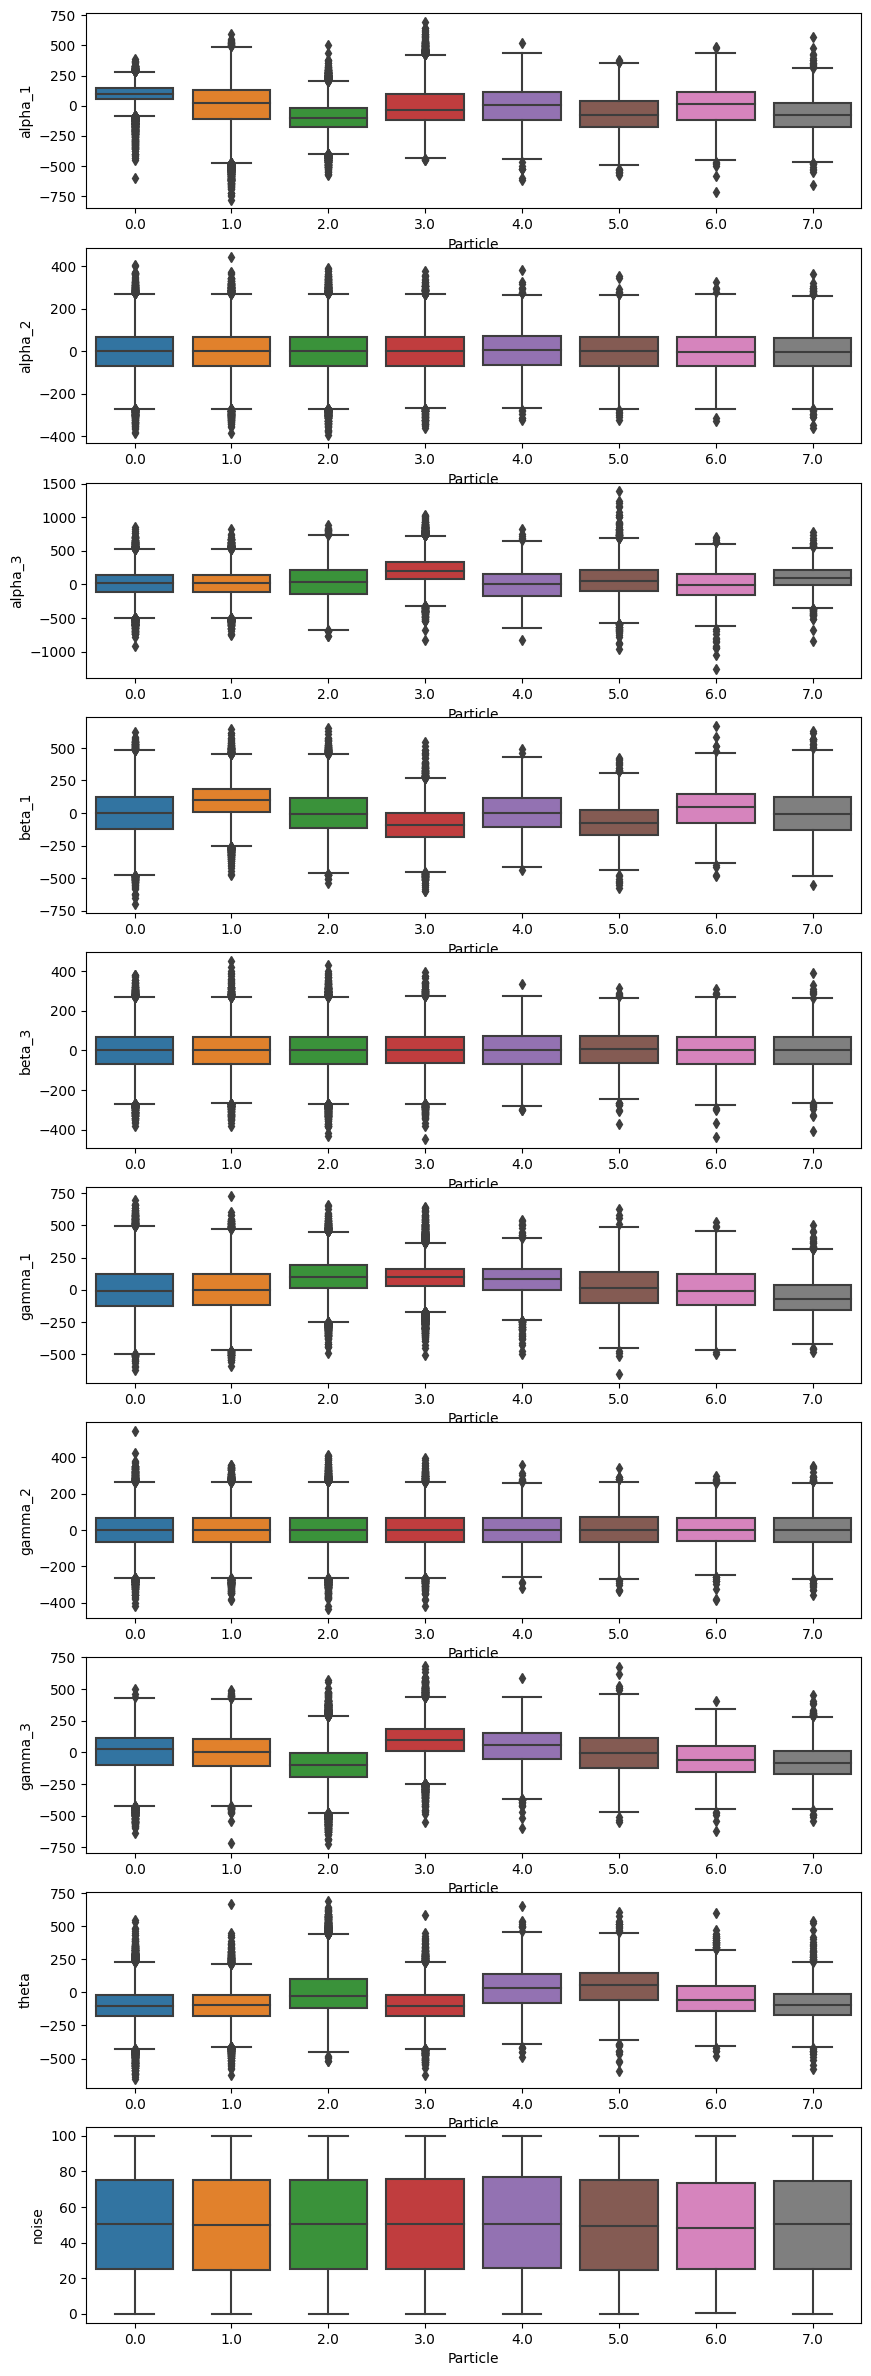

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
#plt.figure(figsize=[10,8]);
f, axes = plt.subplots(10, figsize = (10,30))
for i in range(10):
  sb.boxplot(x='Particle',y=df3.columns[i],data=df3, ax=axes[i])

As shown, there are no outstanding outliers within each of the classes that could be cumbersome to deal with by the corresponding classifiers we might devise.

Further on, we could carry out a Multivariate Outlier detection, but it has been proved that authomatic techniques of outlier detections from a multivariate perspective tend to perform poorly with datasets of more than 4-5 features, which is the case, since they are prone to remove information that will be necessary later on. Consequently, we stick with the univariate analysis.

A final insight we can draw from the previous plots is that some classes are very similar in many of the variables. In those variables that are excessively similar, we will see later on that we can get rid of them, since they are not adding any value to the predictions. Nevertheless, these plots showcase the difficulty of classifying new observations from the existing classes given the aforementioned variables.

### **Balancing class proportions**

Since it is another issue we detected earlier on and it will likely affect the model performance on the least-represented classes, we are going to carry out a data augmentation approach to synthesize new data for those classes in order to be better represented overall.

There are several approaches to do so, but one of the most effectives turns out to be the **SMOTE (Synthetic Minority Oversampling Technique)**. It is based on selecting observations that are close in the n-dimensional space represented by the dataset, drawing a line between the observations in such a feature space, thereby getting a new sample at some point along such a line (so, it is a similar implementation of KNN algorithm to this end).

Here, we could follow **2 approaches aimed at yielding higher F1-Scores**:

*   Since the class '2' is 40 times the least-represented class in the dataset (class '6'), using SMOTE straightforwardly might result in excessively artifficially generated data for such a least-represented class. The same applies to other minority classes. To adress this issue, we could undersample majority classes up to the Average of individuals among all classes, and at the same time oversample the minority classes up to such an Average by using SMOTE.

*   We could use straightforwardly SMOTE to balance all classes based on the majority class, and see the results this dataset yields further on.

Applying some rationale here, bearing in mind that our main goal is to improve the F1-Score from the 'Macro' criterion, it would not make sense to get the majority classes as reference and artifficially create data observations up to such a size. Instead, it seems wiser to determine a reasonable middle point in terms of class proportions (such as the 'Mean' of all class observations), and then use SMOTE to synthetize up to such value the minority classes.

Furthermore, by doing so we will make more efficient the Machine Learning algorithms we might train later on, thereby improving model performance with almost similar results than using straightforwardly SMOTE, if not better.

Consequently, **we are going to follow the 'Mean' approach from now on**:



In [ ]:
# Approach 1: Using the Mean:
class_mean = round(df3.Particle.value_counts().values.mean())

# Oversampling the minority classes:
smote = SMOTE(sampling_strategy={6.0:class_mean, 4.0:class_mean, 5.0:class_mean,
                                 7.0:class_mean})

# Undersampling the majority classes that are above such a mean:
under = RandomUnderSampler(sampling_strategy={2.0:class_mean, 0.0:class_mean, 1.0:class_mean, 3.0:class_mean}, random_state=42)
steps = [('smote', smote), ('underSample', under)]
pipeline = Pipeline(steps=steps)

# Transforming the dataset:
X_m, y_m = pipeline.fit_resample(df3.drop('Particle', 1), df3['Particle'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
# Recreating the DataFrame:
df3_mean = pd.DataFrame(np.column_stack([X_m, y_m]), columns=df3.columns)
df3_mean.head()

,alpha_1,alpha_2,alpha_3,beta_1,beta_3,gamma_1,gamma_2,gamma_3,theta,noise,Particle
0,182.597788,35.122119,-100.217551,-8.010497,98.746238,20.756132,25.728247,96.621981,13.618418,56.869075,0.0
1,76.669664,-1.659872,160.208702,118.625940,150.733056,106.862457,-24.956870,150.225097,-258.264303,41.624493,0.0
2,192.899499,74.837995,28.521765,-203.215601,27.593200,-162.783331,-183.482384,-91.813653,-79.632849,65.970580,0.0
3,60.771169,193.501481,88.349415,119.429046,115.145268,-8.281025,120.266256,122.583947,-185.085249,14.842843,0.0
4,207.851962,-54.581509,-270.995247,174.918837,-12.722178,-391.216816,60.446084,-65.232541,-77.315893,1.852152,0.0


In [ ]:
# Checking value counts:
df3_mean.Particle.value_counts()

0.0    15915
4.0    15915
3.0    15915
1.0    15915
7.0    15915
2.0    15915
5.0    15915
6.0    15915
Name: Particle, dtype: int64

### **Feature Engineering**

Finally, we will create some different variables by combining the existing ones, which is known as Feature Engineering. Since we lack Domain Knowledge about the underlying meaning of the present features, as well as our main goal from a Machine Learning standpoint is to get the highest metrics given the available data (in our case, the F1-Score metric), we will use all available power to combine and create in all possible ways all existing features.

To do so, we are going to use a Python library called 'featuretools', which was initially conceived to be used in relational database, but we can make use of its 'transformation functions' for single DataFrame as well to achieve our goal.

In [ ]:
# All available operations to manipulate the existing features:
ft.list_primitives()

,name,type,dask_compatible,koalas_compatible,description,valid_inputs,return_type
0,percent_true,aggregation,True,False,Determines the percent of `True` values.,Boolean,Numeric
1,num_unique,aggregation,True,True,"Determines the number of distinct values, igno...",Discrete,Numeric
2,min,aggregation,True,True,"Calculates the smallest value, ignoring `NaN` ...",Numeric,Numeric
3,trend,aggregation,False,False,Calculates the trend of a variable over time.,"DatetimeTimeIndex, Numeric",Numeric
4,mean,aggregation,True,True,Computes the average for a list of values.,Numeric,Numeric
...,...,...,...,...,...,...,...
74,haversine,transform,False,False,Calculates the approximate haversine distance ...,LatLong,Numeric
75,less_than_equal_to,transform,True,True,Determines if values in one list are less than...,"Datetime, Numeric, Ordinal",Boolean
76,modulo_numeric,transform,True,True,Element-wise modulo of two lists.,Numeric,Numeric
77,second,transform,True,True,Determines the seconds value of a datetime.,Datetime,Numeric


In [ ]:
# initialize entityset (DataFrame that 'featuretools' use to deal with the data) to apply the library functions:
es = ft.EntitySet(id = 'particles_entitySet')
es = es.entity_from_dataframe(
    entity_id='particles_entitySet',
    dataframe=df3_mean,
    index = 'id',
    variable_types={
        'alpha_1': ft.variable_types.Numeric,
        'alpha_2': ft.variable_types.Numeric,
        'alpha_3': ft.variable_types.Numeric,
        'alpha_3': ft.variable_types.Numeric,
        'beta_1': ft.variable_types.Numeric,
        'beta_3': ft.variable_types.Numeric,
        'gamma_1': ft.variable_types.Numeric,
        'gamma_2': ft.variable_types.Numeric,
        'gamma_3': ft.variable_types.Numeric,
        'theta': ft.variable_types.Numeric,
        'noise': ft.variable_types.Numeric,
        'Particle': ft.variable_types.Categorical,
    }
)

/usr/local/lib/python3.7/dist-packages/featuretools/entityset/entity.py:463: UserWarning: index id not found in dataframe, creating new integer column
  "integer column".format(index))


In [ ]:
# Carrying out the Feature Engineering with all possible transformations that deals with 'Numeric' datatypes, which is the type we assigned to the
# dataset we have just created to deal with the FeatureTools library:
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity="particles_entitySet", trans_primitives = ['add_numeric', 'multiply_numeric', 'modulo_by_feature',
                                                                                                             'modulo_numeric', 'divide_numeric_scalar', 'diff',
                                                                                                             'cum_max', 'subtract_numeric_scalar', 'cum_mean',
                                                                                                             'add_numeric_scalar', 'cum_sum', 'modulo_numeric_scalar',
                                                                                                             'divide_by_feature', 'divide_numeric', 'percentile',
                                                                                                             'subtract_numeric', 'multiply_numeric_scalar',
                                                                                                             'scalar_subtract_numeric_feature', 'cum_min'])

/usr/local/lib/python3.7/dist-packages/featuretools/synthesis/deep_feature_synthesis.py:152: UserWarning: Only one entity in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn("Only one entity in entityset, changing max_depth to "


In [ ]:
# New DataFrame descriptive statistics:
feature_matrix.describe()

,alpha_1,alpha_2,alpha_3,beta_1,beta_3,gamma_1,gamma_2,gamma_3,theta,noise,Particle,alpha_1 + alpha_2,alpha_1 + alpha_3,alpha_1 + beta_1,alpha_1 + beta_3,alpha_1 + gamma_1,alpha_1 + gamma_2,alpha_1 + gamma_3,alpha_1 + noise,alpha_1 + theta,alpha_2 + alpha_3,alpha_2 + beta_1,alpha_2 + beta_3,alpha_2 + gamma_1,alpha_2 + gamma_2,alpha_2 + gamma_3,alpha_2 + noise,alpha_2 + theta,alpha_3 + beta_1,alpha_3 + beta_3,alpha_3 + gamma_1,alpha_3 + gamma_2,alpha_3 + gamma_3,alpha_3 + noise,alpha_3 + theta,beta_1 + beta_3,beta_1 + gamma_1,beta_1 + gamma_2,beta_1 + gamma_3,beta_1 + noise,...,alpha_2 - noise,alpha_2 - theta,alpha_3 - beta_1,alpha_3 - beta_3,alpha_3 - gamma_1,alpha_3 - gamma_2,alpha_3 - gamma_3,alpha_3 - noise,alpha_3 - theta,beta_1 - beta_3,beta_1 - gamma_1,beta_1 - gamma_2,beta_1 - gamma_3,beta_1 - noise,beta_1 - theta,beta_3 - gamma_1,beta_3 - gamma_2,beta_3 - gamma_3,beta_3 - noise,beta_3 - theta,gamma_1 - gamma_2,gamma_1 - gamma_3,gamma_1 - noise,gamma_1 - theta,gamma_2 - gamma_3,gamma_2 - noise,gamma_2 - theta,gamma_3 - noise,gamma_3 - theta,noise - theta,alpha_1 - 0,alpha_2 - 0,alpha_3 - 0,beta_1 - 0,beta_3 - 0,gamma_1 - 0,gamma_2 - 0,gamma_3 - 0,noise - 0,theta - 0
count,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,...,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000,127320.000000
mean,-19.827867,-0.677425,52.165412,-1.947833,1.635925,28.825098,0.019641,-12.475439,-44.578988,50.193972,3.500000,-20.505292,32.337545,-21.775700,-18.191942,8.997231,-19.808226,-32.303306,30.366105,-64.406855,51.487987,-2.625258,0.958500,28.147672,-0.657784,-13.152864,49.516547,-45.256414,50.217579,53.801337,80.990510,52.185053,39.689973,102.359384,7.586423,-0.311908,26.877265,-1.928192,-14.423272,48.246139,...,-50.871397,43.901563,54.113245,50.529487,23.340314,52.145771,64.640851,1.971440,96.744400,-3.583758,-30.772931,-1.967474,10.527606,-52.141805,42.631155,-27.189172,1.616284,14.111364,-48.558047,46.214914,28.805456,41.300537,-21.368874,73.404086,12.495080,-50.174331,44.598630,-62.669411,32.103549,94.772960,-19.827867,-0.677425,52.165412,-1.947833,1.635925,28.825098,0.019641,-12.475439,50.193972,-44.578988
std,154.528172,94.766107,227.926806,162.442910,94.995605,157.972996,95.128109,157.267487,150.914379,26.946436,2.291297,181.327593,210.044684,231.773510,182.788286,216.327888,180.820417,244.679692,156.933565,209.097708,246.782209,188.176621,134.672401,184.410148,134.205962,183.837246,98.756886,178.276833,186.908535,245.964927,285.618967,247.791381,306.557335,229.499230,183.787841,188.876292,206.631891,187.688185,229.514818,164.965362,...,98.287987,178.126080,348.915255,247.892804,268.763834,246.169460,243.700600,229.529044,340.108198,187.481931,244.927733,188.804813,222.630796,164.359510,220.430450,184.226398,134.478393,182.528116,98.957239,178.027962,184.089957,225.614567,160.496232,206.585305,183.828607,98.893403,178.577242,159.276778,225.504971,153.467720,154.528172,94.766107,227.926806,162.442910,94.995605,157.972996,95.128109,157.267487,26

In [ ]:
# Removing variables that have used the 'index' variable, since it does not make sense to take into account, as well as specific variables that results from
# the previous process which get NA values:
df_feat = feature_matrix[feature_matrix.columns.drop(list(feature_matrix.filter(regex='index')))]
df_feat = df_feat[df_feat.columns.drop(list(df_feat.filter(regex='DIFF')))]

In [ ]:
# Final DataFrame once applied Feature Engineering:
df_feat.head()

,alpha_1,alpha_2,alpha_3,beta_1,beta_3,gamma_1,gamma_2,gamma_3,theta,noise,Particle,alpha_1 + alpha_2,alpha_1 + alpha_3,alpha_1 + beta_1,alpha_1 + beta_3,alpha_1 + gamma_1,alpha_1 + gamma_2,alpha_1 + gamma_3,alpha_1 + noise,alpha_1 + theta,alpha_2 + alpha_3,alpha_2 + beta_1,alpha_2 + beta_3,alpha_2 + gamma_1,alpha_2 + gamma_2,alpha_2 + gamma_3,alpha_2 + noise,alpha_2 + theta,alpha_3 + beta_1,alpha_3 + beta_3,alpha_3 + gamma_1,alpha_3 + gamma_2,alpha_3 + gamma_3,alpha_3 + noise,alpha_3 + theta,beta_1 + beta_3,beta_1 + gamma_1,beta_1 + gamma_2,beta_1 + gamma_3,beta_1 + noise,...,alpha_2 - noise,alpha_2 - theta,alpha_3 - beta_1,alpha_3 - beta_3,alpha_3 - gamma_1,alpha_3 - gamma_2,alpha_3 - gamma_3,alpha_3 - noise,alpha_3 - theta,beta_1 - beta_3,beta_1 - gamma_1,beta_1 - gamma_2,beta_1 - gamma_3,beta_1 - noise,beta_1 - theta,beta_3 - gamma_1,beta_3 - gamma_2,beta_3 - gamma_3,beta_3 - noise,beta_3 - theta,gamma_1 - gamma_2,gamma_1 - gamma_3,gamma_1 - noise,gamma_1 - theta,gamma_2 - gamma_3,gamma_2 - noise,gamma_2 - theta,gamma_3 - noise,gamma_3 - theta,noise - theta,alpha_1 - 0,alpha_2 - 0,alpha_3 - 0,beta_1 - 0,beta_3 - 0,gamma_1 - 0,gamma_2 - 0,gamma_3 - 0,noise - 0,theta - 0
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,182.597788,35.122119,-100.217551,-8.010497,98.746238,20.756132,25.728247,96.621981,13.618418,56.869075,0.0,217.719907,82.380237,174.587291,281.344026,203.353920,208.326035,279.219768,239.466862,196.216206,-65.095432,27.111622,133.868357,55.878251,60.850366,131.744100,91.991194,48.740537,-108.228048,-1.471313,-79.461418,-74.489304,-3.595570,-43.348476,-86.599133,90.735741,12.745636,17.717750,88.611484,48.858578,...,-21.746956,21.503701,-92.207054,-198.963789,-120.973683,-125.945798,-196.839531,-157.086625,-113.835969,-106.756734,-28.766629,-33.738744,-104.632477,-64.879571,-21.628915,77.990105,73.017991,2.124257,41.877163,85.127820,-4.972115,-75.865848,-36.112942,7.137714,-70.893734,-31.140828,12.109829,39.752906,83.003562,43.250656,182.597788,35.122119,-100.217551,-8.010497,98.746238,20.756132,25.728247,96.621981,56.869075,13.618418
1,76.669664,-1.659872,160.208702,118.625940,150.733056,106.862457,-24.956870,150.225097,-258.264303,41.624493,0.0,75.009792,236.878366,195.295604,227.402720,183.532121,51.712794,226.894761,118.294157,-181.594639,158.548830,116.966068,149.073184,105.202585,-26.616742,148.565225,39.964621,-259.924175,278.834642,310.941758,267.071159,135.251832,310.433799,201.833195,-98.055601,269.358996,225.488397,93.669069,268.851037,160.250432,...,-43.284365,256.604431,41.582762,9.475646,53.346245,185.165572,9.983605,118.584209,418.473005,-32.107116,11.763483,143.582810,-31.599157,77.001447,376.890243,43.870599,175.689926,0.507959,109.108563,408.997359,131.819327,-43.362640,65.237964,365.126760,-175.181968,-66.581363,233.307433,108.600604,408.489400,299.888796,76.669664,-1.659872,160.208702,118.625940,150.733056,106.862457,-24.956870,150.225097,41.624493,-258.264303
2,192.899499,74.837995,28.521765,-203.215601,27.593200,-162.783331,-183.482384,-91.813653,-79.632849,65.970580,0.0,267.737493,221.421263,-10.316102,220.492699,30.116167,9.417115,101.085845,258.870079,113.266650,103.359759,-128.377606,102.431195,-87.945337,-108.644389,-16.975659,140.808575,-4.794854,-174.693836,56.114965,-134.261567,-154.960619,-63.291889,94.492345,-51.111084,-175.622400,-365.998932,-386.697985,-295.029254,-137.245020,...,8.867414,154.470843,231.737365,0.928564,191.305096,212.004148,120.335418,-37.448816,108.154613,-230.808801,-40.432270,-19.733217,-111.401947,-269.186181,-123.582752,190.376532,211.075584,119.406854,-38.377380,107.226049,20.699053,-70.969678,-228.753912,-83.150483,-91.668730,-249.452964,-103.849535,-157.784234,-12.180805,145.603429,192.899499,74.837995,28.521765,-203.215601,27.593200,-162.783331,-183.482384,-91.813653,65.970580,-79.632849
3,60.771169,193.501481,88.349415,119.429046,115.145268,-8.281025,120.266256,122.583947,-185.085249,14.842843,0.0,254.272650,149.120

In [ ]:
# Checking NA:
df_feat.isna().sum().sum()

0

### **Feature Selection**

Now, we will discard the unrelevant features by relying on the **F of Fisher**, a statistic that compares if there is a statistically significant difference between a continuous variable (each new variable we might create) and a categorical one (our response variable 'Particle') by comparing the inner distributions of these variables within each class:

In [ ]:
test = f_regression(df_feat.drop('Particle', 1), df_feat['Particle'].values)

In [ ]:
# Creating a dictionary to manipulate columns:
cols = df_feat.drop('Particle', 1).columns
col_dict = dict(zip(cols, test[1])) # Accessing to the tuple part where the 'p-values' of each feature have been stored.

In [ ]:
# Since we are dealing with a huge dataset, we set our threshold for the p-values
# we will be comparing for each variable, resulting from the F of Fisher statistic,
# straightforwardly to '0', so that only absolutely relevant features with regard to
# the Response Variable will be kept in the dataset:
for key, value in col_dict.items():
  if value > 0.0:
    df_feat = df_feat.drop(key,1)
  else:
    print('Feature: {},  p-value: {}'.format(key, value))

Feature: alpha_1,  p-value: 0.0
Feature: gamma_1,  p-value: 0.0
Feature: theta,  p-value: 0.0
Feature: alpha_1 + alpha_2,  p-value: 0.0
Feature: alpha_1 + alpha_3,  p-value: 0.0
Feature: alpha_1 + beta_1,  p-value: 0.0
Feature: alpha_1 + beta_3,  p-value: 0.0
Feature: alpha_1 + gamma_1,  p-value: 0.0
Feature: alpha_1 + gamma_2,  p-value: 0.0
Feature: alpha_1 + gamma_3,  p-value: 0.0
Feature: alpha_1 + noise,  p-value: 0.0
Feature: alpha_3 + theta,  p-value: 0.0
Feature: beta_1 + gamma_1,  p-value: 0.0
Feature: beta_1 + gamma_3,  p-value: 0.0
Feature: gamma_1 + gamma_3,  p-value: 0.0
Feature: gamma_1 + noise,  p-value: 0.0
Feature: noise + theta,  p-value: 0.0
Feature: alpha_1 + 0,  p-value: 0.0
Feature: gamma_1 + 0,  p-value: 0.0
Feature: theta + 0,  p-value: 0.0
Feature: CUM_MAX(alpha_1),  p-value: 0.0
Feature: CUM_MAX(alpha_2),  p-value: 0.0
Feature: CUM_MAX(alpha_3),  p-value: 0.0
Feature: CUM_MAX(beta_1),  p-value: 0.0
Feature: CUM_MAX(beta_3),  p-value: 0.0
Feature: CUM_MAX(gamma_

In [ ]:
# How many variables do we finally have in our dataset?
df_feat.shape

(127320, 100)

# **Normalization**

Since we are going to use models that are influenced by the scale in which each variable is measured, we decide to standardize the predictor variables. Otherwise, models such as Support Vector Machines would suffer, since when trying to perform the Optimal Separating Hyper-Plane (OSH) in the Feature Space that the Kernel Function maps the observations to, one dimension would dominate over the other ones and a bias in the explanatory capability of the target classes would arise.

In addition to this, we are going to apply **Principal Component Analysis (PCA)** as a dimensionality reduction tool, since by doing so we will gather the entropy within the dataset in each of the resulting Principal Components, thereby getting rid at the same time of the existing noise and leading to more accurate predictions.

In terms of the Principal Components to retain, we will do so by setting the accumulated variance we need to keep, and the corresponding number of Principal Components will result from that.

Finally, we split the dataset into train and test datasets, and we set a 'random_state', so that the results among models become reliable to compare.

In [ ]:
num_c = df_feat.columns[df_feat.columns != "Particle"]

In [ ]:
scaler = StandardScaler()
df_feat[num_c] = scaler.fit_transform(df_feat.drop('Particle', axis = 1))

In [ ]:
# Applying PCA as a dimensionality reduction technique, and setting the accumulated variance to 0.99, as we aim to get the highest possible metrics:
pca = PCA(.99)
pca.fit(df_feat[num_c])

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
# Principal Components retained:
pca.n_components_

35

In [ ]:
# Transforming the Dataset:
df_pca = pca.transform(df_feat[num_c])
df_pca = pd.concat([pd.DataFrame(df_pca), df_feat['Particle']], axis=1)

In [ ]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,Particle
0,23.098567,15.127283,4.428004,16.637222,49.002723,2.075491,-9.760222,-3.863273,8.322253,-12.584443,10.752343,17.673396,88.901506,60.150192,26.084893,-23.226551,8.261665,3.480172,4.524983,13.226379,57.708505,-10.010937,3.874294,0.495802,-0.573364,-0.748545,-0.066090,0.127627,-0.888109,-0.402117,0.170166,-0.821932,1.677543,1.214021,2.748740,0.0
1,22.803759,19.560062,6.121500,8.582987,38.642003,0.171515,-9.572794,-1.815329,-1.543742,2.127626,46.733508,43.350199,83.295509,35.673927,40.351302,-6.415703,7.251943,0.982556,2.269289,7.547797,35.848922,-3.921649,35.463774,8.578744,0.315586,-0.528278,0.413680,-0.690195,0.376787,-0.214807,-0.000641,-0.629167,-0.103881,-0.351650,-2.233568,0.0
2,29.525261,25.156865,5.398507,17.542689,27.898849,4.472023,-5.901517,-18.548266,3.910167,24.985146,86.104777,71.868824,70.048839,6.568338,50.495758,14.915222,8.458197,-0.604999,2.653304,2.931515,8.342350,2.963033,-36.554414,-8.960502,-0.022518,-0.757727,0.007325,-0.105322,-0.483101,-0.928376,-1.340474,1.077515,2.707615,5.254886,18.456048,0.0
3,28.288664,26.053216,5.894237,16.698367,50.291040,7.227986,-10.138001,-13.015978,15.578004,0.686612,22.969670,40.599956,84.762052,20.651144,85.152359,30.821640,24.957761,0.705365,3.441110,7.869773,27.954944,40.353515,6.263420,0.543110,0.810787,-0.088081,-0.520857,-0.995799,0.351821,0.659444,-0.201813,0.396241,1.098036,3.466450,13.898510,0.0
4,31.393916,24.522527,10.445018,22.433814,45.582506,1.768435,-2.952474,8.278107,7.142738,-6.482627,7.028244,23.105934,55.300957,12.220954,73.534695,31.693393,21.634742,-2.014213,2.134396,2.264625,10.047018,42.342284,48.617718,9.388232,0.229646,-0.586400,1.115059,0.434812,0.914921,1.056461,-0.539879,0.105510,-1.007396,-1.181076,-3.151482,0.0


In [ ]:
df_pca.shape

(127320, 36)

In [ ]:
X = df_pca.drop('Particle', axis = 1) # Drop column on the column axis
y = df_pca['Particle'].values         # df['class'] gives us a pandas series, we need an array, which can be obtained using .values

Let's finally split the data into training-test datasets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

In [ ]:
X_train.shape

(84880, 35)

In [ ]:
# Functions to output more accurate results and plot the training evolution of the Neural Network:
def print_acc(conf_mat):
    classes = conf_mat.shape[1]
    i = 0
    ok = 0
    while i < classes:
      ok += conf_mat[i,i]
      i += 1
    return(ok/sum(sum(conf_mat)))

def get_intervals(f1_score, n):
    f1_score = f1_score/100
    SD_int = 1.967*math.sqrt((f1_score*(1-f1_score))/n)
    return round((f1_score-SD_int)*100, 2), round((f1_score+SD_int)*100, 2)

test_n = X_test.shape[0]

# **Data Processing 1: Linear Discriminant Analysis (LDA)**

We start by using a **Linear Discriminative Classifier (LDA)** as a  baseline to overcome for the rest of the classifiers, since it is the most simple, albeit equally effective, classifier we may make use of (a Generative Bayesian Classifier, which takes into account the distribution of the classes, as well as the existing Prior Probabilities).

More precisely, it performs a Hyper-Plane resulting as the mathematical boundary between 2 or more (in our case, 8) centroids in the n-dimensional space simply defined by our predictor variables (35-dimensional space, in our case), assuming that all 8 classes share the same Covariance Matrix from their Multivariate Gaussian Distribution with regard to such 35 predictor variables (resulting Principal Components). This doesn't have to be true, but it is a good assumption to start with.

It is worth-pointing out (sometimes it is overlooked) that **all classes must follow a Multivariate Gaussian Distribution**, since it is assumed as the basic equation to perform the Hyper-Plane. We don't know such an information as we don't know the actual meaning of the variables, but by the Central Limit Theorem we can assert that all variables that are made, in turn, by many other variables tend to follow a Gaussian Distribution as there are more variables involved that the current predictor variables depend on.

Since they are nature processes (particle behaviour), and every nature process is made of, in turn, many other variables and processes that affect it, we can reliably assume that the existing 8 classes tend to follow a Multivariate Gaussian Distribution and, therefore, make use of the LDA Classifier accordingly from a theoretical and mathematical standpoint. In addition to this, if looking at the histograms of the variables, all histograms tend to follow a Gaussian Distribution Probability Density Function, so these assumptions will likely hold for the present dataset.

In [ ]:
# LDA as a baseline:
LDA = LinearDiscriminantAnalysis(solver='eigen')

In [ ]:
LDA.fit(X_train, y_train)
LDA_pred = LDA.predict(X_test)
LDA_cf = confusion_matrix(y_test, LDA_pred)

In [ ]:
print("Accuracy: " + str(round((print_acc(LDA_cf))*100,2)) + "%")
print("Error: " + str(round((1-print_acc(LDA_cf))*100,2)) + "%")
print("Confusion Matrix:")
pd.DataFrame(
    LDA_cf,
    index= ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks'],
    columns= ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks']
)

Accuracy: 94.68%
Error: 5.32%
Confusion Matrix:


,Leptons,Quarks,Gluons,Electroweak bosons,Graviton,Higgs boson,Antileptons,Antiquarks
Leptons,5265,7,0,0,1,0,1,0
Quarks,251,5037,0,0,0,0,0,0
Gluons,0,571,4873,0,0,0,0,0
Electroweak bosons,0,0,119,4605,550,0,0,0
Graviton,0,0,0,0,5366,0,0,0
Higgs boson,0,0,0,0,231,5050,20,0
Antileptons,0,0,0,0,0,96,5179,0
Antiquarks,0,0,0,0,0,0,409,4809


In [ ]:
print("Classification Metrics: \n" + classification_report(y_test, LDA_pred,
                                                           target_names= ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks']))

Classification Metrics: 
                    precision    recall  f1-score   support

           Leptons       0.95      1.00      0.98      5274
            Quarks       0.90      0.95      0.92      5288
            Gluons       0.98      0.90      0.93      5444
Electroweak bosons       1.00      0.87      0.93      5274
          Graviton       0.87      1.00      0.93      5366
       Higgs boson       0.98      0.95      0.97      5301
       Antileptons       0.92      0.98      0.95      5275
        Antiquarks       1.00      0.92      0.96      5218

          accuracy                           0.95     42440
         macro avg       0.95      0.95      0.95     42440
      weighted avg       0.95      0.95      0.95     42440



In [ ]:
LDA_f1 = round(f1_score(y_test, LDA_pred, average='macro')*100, 2)
LDA_f1_low, LDA_f1_up = get_intervals(LDA_f1, test_n)
print("LDA F1-Score with Macro criterion:   {}% with a Confidence Interval of ({}%, {}%) at 95% confidence.".format(LDA_f1, LDA_f1_low, LDA_f1_up))

LDA F1-Score with Macro criterion:   94.7% with a Confidence Interval of (94.49%, 94.91%) at 95% confidence.


# **Data Processing 2: Quadratic Discriminant Analysis (QDA)**

Now, once we have defined our baseline to outperform, which is amazingly high, we can use QDA and estimate each of the Covariance Matrix with the available data and, if getting better results than with LDA, we can assume that the Covariance Matrix becomes different for each of the classes.

This entails having to estimate the Covariance Matrix for each of the classes by the model. If there is no sufficient data, the classification by QDA might result worse than the theoretical one. With 84880 observations with the training data to estimate 8 Covariance Matrices of 35 dimensions each, it seems relatively substantial data to get a classification close to the theoretical one. If the resulting metrics happen to be higher than in LDA, it will entail that Covariance Matrices of each of the Multivariate Gaussian Distribution of the classes ends up being different, so it is worth-performing a QDA here.

In [ ]:
QDA = QuadraticDiscriminantAnalysis()
QDA.fit(X_train, y_train)
QDA_pred = QDA.predict(X_test)
QDA_cf = confusion_matrix(y_test, QDA_pred)

In [ ]:
print("Accuracy: " + str(round((print_acc(QDA_cf))*100,2)) + "%")
print("Error: " + str(round((1-print_acc(QDA_cf))*100,2)) + "%")
print("Confusion Matrix:")
pd.DataFrame(
    QDA_cf,
    index= ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks'],
    columns= ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks']
)

Accuracy: 99.45%
Error: 0.55%
Confusion Matrix:


,Leptons,Quarks,Gluons,Electroweak bosons,Graviton,Higgs boson,Antileptons,Antiquarks
Leptons,5259,15,0,0,0,0,0,0
Quarks,3,5282,3,0,0,0,0,0
Gluons,0,6,5438,0,0,0,0,0
Electroweak bosons,0,0,49,5156,69,0,0,0
Graviton,0,0,0,0,5366,0,0,0
Higgs boson,0,0,0,0,10,5290,1,0
Antileptons,0,0,0,0,0,44,5201,30
Antiquarks,0,0,0,0,0,0,3,5215


In [ ]:
print("Classification Metrics: \n" + classification_report(y_test, QDA_pred,
                                                           target_names = ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks']))

Classification Metrics: 
                    precision    recall  f1-score   support

           Leptons       1.00      1.00      1.00      5274
            Quarks       1.00      1.00      1.00      5288
            Gluons       0.99      1.00      0.99      5444
Electroweak bosons       1.00      0.98      0.99      5274
          Graviton       0.99      1.00      0.99      5366
       Higgs boson       0.99      1.00      0.99      5301
       Antileptons       1.00      0.99      0.99      5275
        Antiquarks       0.99      1.00      1.00      5218

          accuracy                           0.99     42440
         macro avg       0.99      0.99      0.99     42440
      weighted avg       0.99      0.99      0.99     42440



In [ ]:
QDA_f1 = round(f1_score(y_test, QDA_pred, average='macro')*100, 2)
QDA_f1_low, QDA_f1_up = get_intervals(QDA_f1, test_n)
print("QDA F1-Score with Macro criterion:   {}% with a Confidence Interval of ({}%, {}%) at 95% confidence.".format(QDA_f1, QDA_f1_low, QDA_f1_up))

QDA F1-Score with Macro criterion:   99.45% with a Confidence Interval of (99.38%, 99.52%) at 95% confidence.


# **Data Processing 3: Support Vector Machine with Non-Linear RBF Kernel**

We can use now all potential of Kernel Methods by means of the SVM with a RBF Kernel (Hyper-sphere as a Feature Space with infinite dimensions), since it is the most powerful Kernel Function that already includes the Polynomial Kernel Function.

We are going to define the 'f1_macro' as a scoring criterion to choose the optimal parameters for 'C' and 'gamma', and use such a best model to make predictions.

In [ ]:
# Refining parameters:
gsc = GridSearchCV(
        estimator=svm.SVC(kernel='rbf'),#  base model 
        param_grid={
            'C': [10, 100],
            'gamma': [0.001, 0.01]
        }, # parameters to test
        cv=2, # number of folds, we low it up to just '2', given the dataset size and the available computational power.
        scoring='f1_macro', # metric for cv selection
        verbose=1, # verbosity level
        n_jobs=-1, # parallel jobs 
        return_train_score=False, # obtain train scores 
        refit=True) # refit best model with the entire dataset

svm_grid = gsc.fit(X_train, y_train)

print("Best params:",svm_grid.best_params_)
print("Mean cross-validated score of the best estimator: %f" % svm_grid.best_score_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.7min finished


Best params: {'C': 100, 'gamma': 0.001}
Mean cross-validated score of the best estimator: 0.991223


In [ ]:
svm_grid.best_estimator_.n_support_

array([173, 419, 441, 442, 468, 557, 723, 417], dtype=int32)

In [ ]:
predictions_train=svm_grid.best_estimator_.predict(X_train)

In [ ]:
# Are the classes linearly separable by a Optimal Separating Hyper-Plane in the Feature Space? We check it through the very same training sample to get the answer:
rbf_conf_train = confusion_matrix(y_train, predictions_train)
print("Accuracy: " + str(round((print_acc(rbf_conf_train))*100,2)) + "%")
print("Error: " + str(round((1-print_acc(rbf_conf_train))*100,2)) + "%")
print("Confusion matrix:")
pd.DataFrame(
    rbf_conf_train,
    index= ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks'],
    columns= ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks']
)

Accuracy: 99.38%
Error: 0.62%
Confusion matrix:


,Leptons,Quarks,Gluons,Electroweak bosons,Graviton,Higgs boson,Antileptons,Antiquarks
Leptons,10639,2,0,0,0,0,0,0
Quarks,10,10613,4,0,0,0,0,0
Gluons,0,61,10402,8,0,0,0,0
Electroweak bosons,0,0,33,10511,97,0,0,0
Graviton,0,0,0,7,10542,0,0,0
Higgs boson,0,0,0,0,27,10536,51,0
Antileptons,0,0,0,0,0,140,10491,9
Antiquarks,0,0,0,0,0,0,80,10617


Consequently, we see that even in a huge-dimensional Feature Space that the Kernel Function maps the observations to, there is still some overlap among classes with the present sample, that makes unfeasible a 100% Accuracy and, consequently, a 100% F1-Score, especially for the less represented classes.

In [ ]:
svm_pred=svm_grid.best_estimator_.predict(X_test)

In [ ]:
rbf_conf = confusion_matrix(y_test, svm_pred)
print("Accuracy: " + str(round((print_acc(rbf_conf))*100,2)) + "%")
print("Error: " + str(round((1-print_acc(rbf_conf))*100,2)) + "%")
print("Confusion matrix:")
pd.DataFrame(
    rbf_conf,
    index= ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks'],
    columns= ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks']
)

Accuracy: 99.26%
Error: 0.74%
Confusion matrix:


,Leptons,Quarks,Gluons,Electroweak bosons,Graviton,Higgs boson,Antileptons,Antiquarks
Leptons,5271,3,0,0,0,0,0,0
Quarks,7,5277,4,0,0,0,0,0
Gluons,0,33,5403,8,0,0,0,0
Electroweak bosons,0,0,24,5187,63,0,0,0
Graviton,0,0,0,5,5361,0,0,0
Higgs boson,0,0,0,0,10,5264,27,0
Antileptons,0,0,0,0,0,66,5201,8
Antiquarks,0,0,0,0,0,0,54,5164


In [ ]:
print("Classification Metrics: \n" + classification_report(y_test, svm_pred,
                            target_names = ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks']))

Classification Metrics: 
                    precision    recall  f1-score   support

           Leptons       1.00      1.00      1.00      5274
            Quarks       0.99      1.00      1.00      5288
            Gluons       0.99      0.99      0.99      5444
Electroweak bosons       1.00      0.98      0.99      5274
          Graviton       0.99      1.00      0.99      5366
       Higgs boson       0.99      0.99      0.99      5301
       Antileptons       0.98      0.99      0.99      5275
        Antiquarks       1.00      0.99      0.99      5218

          accuracy                           0.99     42440
         macro avg       0.99      0.99      0.99     42440
      weighted avg       0.99      0.99      0.99     42440



In [ ]:
svm_f1 = round(f1_score(y_test, svm_pred, average='macro')*100, 2)
svm_f1_low, svm_f1_up = get_intervals(svm_f1, test_n)
print("SVM F1-Score with Macro criterion:   {}% with a Confidence Interval of ({}%, {}%) at 95% confidence.".format(svm_f1, svm_f1_low, svm_f1_up))

SVM F1-Score with Macro criterion:   99.26% with a Confidence Interval of (99.18%, 99.34%) at 95% confidence.


# **Data Processing 4: Random Forest**

Let's now use an Ensemble Method to see if we are able to capture the Regular Patterns of the data and get rid of the existing noise. To do so, we are going to use a Random Forest made of CART Decision Trees using Gini Index Impurity split criterion, and choosing the optimal number of subset of predictor variables to consider in each split of the tree, as well as the number of maximum trees to use in the Random Forest to get the best predictions in terms of the F1-Score.

In [ ]:
# Refining parameters:
# According to all studies, the square root of the number of the predictors
# is the optimal choice of number of predictors to consider in each CART Decision
# Tree split, so this is going to be out starting point for such parameter:
p = round(math.sqrt(X_train.shape[1]))

# In this case, we decide to stick with the default parameters, as the tuning in Random Forest
# does not give outstanding results with regard to the default parameters.
# Given the available computational power, we must stick with them:
gsc = GridSearchCV(
        estimator=RandomForestClassifier(oob_score = True, random_state=42), 
        param_grid={
            'n_estimators': [100],
            'max_features': [p]
        }, # parameters to test
        cv=2, # number of folds, we low it up to just '2', given the dataset size and the available computational power.
        scoring='f1_macro', # metric for cv selection
        verbose=1, # verbosity level
        n_jobs=-1, # parallel jobs 
        return_train_score=False, # obtain train scores 
        refit=True) # refit best model with the entire dataset

rf_grid = gsc.fit(X_train, y_train)

print("Best params:",rf_grid.best_params_)
print("Mean cross-validated score of the best estimator: %f" % rf_grid.best_score_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   43.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   43.5s finished


Best params: {'max_features': 6, 'n_estimators': 100}
Mean cross-validated score of the best estimator: 0.981506


In [ ]:
rf_pred = rf_grid.best_estimator_.predict(X_test)

In [ ]:
rf_conf = confusion_matrix(y_test, rf_pred)
print("Accuracy: " + str(round((print_acc(rf_conf))*100,2)) + "%")
print("Error: " + str(round((1-print_acc(rf_conf))*100,2)) + "%")
print("Confusion matrix:")
pd.DataFrame(
    rf_conf,
    index= ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks'],
    columns= ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks']
)

Accuracy: 98.38%
Error: 1.62%
Confusion matrix:


,Leptons,Quarks,Gluons,Electroweak bosons,Graviton,Higgs boson,Antileptons,Antiquarks
Leptons,5234,40,0,0,0,0,0,0
Quarks,42,5235,11,0,0,0,0,0
Gluons,0,58,5337,49,0,0,0,0
Electroweak bosons,0,0,86,5143,45,0,0,0
Graviton,0,0,0,36,5329,1,0,0
Higgs boson,0,0,0,1,57,5226,17,0
Antileptons,0,0,0,0,0,95,5153,27
Antiquarks,0,0,0,0,0,0,122,5096


In [ ]:
print("Classification Metrics: \n" + classification_report(y_test, rf_pred,
                            target_names = ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks']))

Classification Metrics: 
                    precision    recall  f1-score   support

           Leptons       0.99      0.99      0.99      5274
            Quarks       0.98      0.99      0.99      5288
            Gluons       0.98      0.98      0.98      5444
Electroweak bosons       0.98      0.98      0.98      5274
          Graviton       0.98      0.99      0.99      5366
       Higgs boson       0.98      0.99      0.98      5301
       Antileptons       0.97      0.98      0.98      5275
        Antiquarks       0.99      0.98      0.99      5218

          accuracy                           0.98     42440
         macro avg       0.98      0.98      0.98     42440
      weighted avg       0.98      0.98      0.98     42440



In [ ]:
rf_f1 = round(f1_score(y_test, rf_pred, average='macro')*100, 2)
rf_f1_low, rf_f1_up = get_intervals(rf_f1, test_n)
print("Random Forest F1-Score with Macro criterion:   {}% with a Confidence Interval of ({}%, {}%) at 95% confidence.".format(rf_f1, rf_f1_low, rf_f1_up))

Random Forest F1-Score with Macro criterion:   98.38% with a Confidence Interval of (98.26%, 98.5%) at 95% confidence.


# **Data Processing 5: Gradient Boosted Trees**

Given that the Random Forest yielded the best performance so far and it was able to capture the Regular Structure of the data, we can finally try to outperform it by using a Boosting Machine Learning Method, such as Gradient Boosted Trees.

By using such a Boosting method, we can infer information from each CART Decision Trees that will help to minimize the underlying objective function of the method, which includes a Training Loss Function and a Regularization part. Overall, after choosing the optimal parameters by means of Cross Validation as before (the optimal parameters we state below target both model complexity and they also add randomness to make the training robust to the existing noise within the data), we should be able to outperform the Random Forest and fit the Regular Structure of the data through CART Decision Trees and the information we get from each split. Let's do it:

In [ ]:
# We shoul encode labels to integers to provide them as arguments to this model:
le = LabelEncoder()
le = le.fit(y_train_sub)
y_tr_e = le.transform(y_train)

In [ ]:
xg_a = XGBClassifier(eval_metric = 'mlogloss', use_label_encoder=False)

In [ ]:
# Given the demanding computational power of this model, we are going to stick with the default parameters:
xg_a.fit(X_train, y_tr_e)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

In [ ]:
xg_pred = xg_a.predict(X_test)

In [ ]:
xg_conf = confusion_matrix(y_test, xg_pred)
print("Accuracy: " + str(round((print_acc(xg_conf))*100,2)) + "%")
print("Error: " + str(round((1-print_acc(xg_conf))*100,2)) + "%")
print("Confusion matrix:")
pd.DataFrame(
    xg_conf,
    index = ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks'],
    columns = ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks']
)

Accuracy: 97.57%
Error: 2.43%
Confusion matrix:


,Leptons,Quarks,Gluons,Electroweak bosons,Graviton,Higgs boson,Antileptons,Antiquarks
Leptons,5211,62,0,0,0,1,0,0
Quarks,79,5159,50,0,0,0,0,0
Gluons,0,65,5303,76,0,0,0,0
Electroweak bosons,0,0,101,5107,65,0,0,1
Graviton,0,3,0,48,5308,2,2,3
Higgs boson,0,0,0,3,86,5170,42,0
Antileptons,2,0,0,0,1,130,5089,53
Antiquarks,0,0,0,0,0,1,157,5060


In [ ]:
print("Classification Metrics: \n" + classification_report(y_test, xg_pred,
                            target_names = ['Leptons', 'Quarks', 'Gluons', 'Electroweak bosons', 'Graviton', 'Higgs boson', 'Antileptons', 'Antiquarks']))

Classification Metrics: 
                    precision    recall  f1-score   support

           Leptons       0.98      0.99      0.99      5274
            Quarks       0.98      0.98      0.98      5288
            Gluons       0.97      0.97      0.97      5444
Electroweak bosons       0.98      0.97      0.97      5274
          Graviton       0.97      0.99      0.98      5366
       Higgs boson       0.97      0.98      0.98      5301
       Antileptons       0.96      0.96      0.96      5275
        Antiquarks       0.99      0.97      0.98      5218

          accuracy                           0.98     42440
         macro avg       0.98      0.98      0.98     42440
      weighted avg       0.98      0.98      0.98     42440



In [ ]:
xg_f1 = round(f1_score(y_test, xg_pred, average='macro')*100, 2)
xg_f1_low, xg_f1_up = get_intervals(xg_f1, test_n)
print("Random Forest F1-Score with Macro criterion:   {}% with a Confidence Interval of ({}%, {}%) at 95% confidence.".format(xg_f1, xg_f1_low, xg_f1_up))

Random Forest F1-Score with Macro criterion:   97.57% with a Confidence Interval of (97.42%, 97.72%) at 95% confidence.


# **Final Model Comparative:**

In [ ]:
pd.DataFrame(
    [[LDA_f1, LDA_f1_low, LDA_f1_up],
    [QDA_f1, QDA_f1_low, QDA_f1_up],
    [svm_f1, svm_f1_low, svm_f1_up],
    [rf_f1, rf_f1_low, rf_f1_up]],
    index=["LDA", "QDA", "SVM with RBF Kernel", "Random Forest"],
    columns=["F1-Score", "Upper Conf. Interval", "Lower Conf. Interval"]
)

,F1-Score,Upper Conf. Interval,Lower Conf. Interval
LDA,94.70,94.49,94.91
QDA,99.45,99.38,99.52
SVM with RBF Kernel,99.26,99.18,99.34
Random Forest,98.38,98.26,98.50


# **Conclusions**

As a final insights to put forward, we can assert that **Quadratic Discriminant Analysis is the model with the highest performance when it comes to get higher F1-Scores with the Macro criterion**, since it gets the highest F1-Score with the present sample.

However, **it is worth-outlining that we cannot make such a statement when it comes to predict these 8 classes with whatever other sample we might draw from the population from we got this dataset**. This is because some of the Confidence Intervals at 95% Confidence overlap between SVM and QDA. This means that with another sample SVM might get better performance than QDA, since we have just tested these models with a single sample.

Consequently, **Confidence Intervals play a key role when comparing Machine Learning os Statistical models, since one cannot assert that one model is better than other if their Confidence Intervals overlap.**

The previously proposed classifiers showcased an increase in complexity, especially from **LDA** to **SVM** (with **QDA** in between). **SVM** in this case was not the best choice, since it is a really powerful method when we have a dataset with reasonable cardinality and very high dimensionality, as the Support Vectors from the model are dependent on the number of observations and not on the number of features. Since here we had 35 features to factor in the model, it became not so reliable than in other settings.

However, with QDA **we achieved the higgest F1-Score: 99.45%**, which was not the case in the previous models. This showcases the fact that the classes were driven by Multivariate Gaussian Distributions with different Covariance Matrices and, eventually, it played a key role when using the best classifier overall to deal with these settings: **Quadratic Discriminant Analysys (QDA)**.